In [187]:
import json
import pandas as pd
import numpy as np
import os
import time
from datetime import timedelta
import tensorflow as tf
from PIL import Image
import inception
from inception import transfer_values_cache
from collections import Counter
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data0627_weighted_25Solved.csv')

In [4]:
df['RateClass'].value_counts()

4     14182
12     4590
9      3143
17     1116
Name: RateClass, dtype: int64

In [186]:
pic = []
label = []
app = []
PICNAME = []
for i in range(df.shape[0]):
    try:
        im = Image.open(df['picpath'][i])
        PICNAME.append(df['picname'][i])
        pic.append(np.array(im))
        label.append(df['RateClass'][i])
    except: 
        app.append(df['picname'][i])

In [8]:
df1 = pd.DataFrame(PICNAME, columns = ['picname'])
df1['label'] = label
df1['pic'] = pic

In [10]:
df = df1.merge(df, left_on='picname', right_on='picname',how = 'inner')

In [12]:
df = df.rename(columns={'label_x': 'label'})

In [13]:
df.to_csv('data0627_weighted_2521459pic.csv',index = False)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(pic, label, test_size=0.2, random_state=42)

In [15]:
pd.Series(label).value_counts()

4     13339
12     4193
9      2882
17     1017
dtype: int64

In [17]:
cls_test = y_test

In [18]:
labels_train = []
for i in y_train:
    l_temp = np.zeros(4)
    if i == 4:
        l_temp[0] = 1
    elif i == 9:
        l_temp[1] = 1
    elif i == 12:
        l_temp[2] = 1
    elif i == 17:
        l_temp[3] = 1
    labels_train.append(l_temp)
labels_train = np.array(labels_train)

In [19]:
labels_test = []
for i in y_test:
    l_temp = np.zeros(4)
    if i == 4:
        l_temp[0] = 1
    elif i == 9:
        l_temp[1] = 1
    elif i == 12:
        l_temp[2] = 1
    elif i == 17:
        l_temp[3] = 1
    labels_test.append(l_temp)
labels_test = np.array(labels_test)

In [21]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [22]:
model = inception.Inception()

Instructions for updating:
Use tf.gfile.GFile.


In [27]:
path = 'C:\\Users\\MAX\\Desktop\\PROFYILU\\APPDATA\\IMAGE\\IMAGE\\'

In [28]:
file_path_cache_train = os.path.join(path, 'inception25train.pkl')
file_path_cache_test = os.path.join(path, 'inception25test.pkl')

In [52]:
images_scaled = np.array(X_train)
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

- Data loaded from cache-file: C:\Users\MAX\Desktop\PROFYILU\APPDATA\IMAGE\IMAGE\inception25train.pkl


In [51]:
images_scaled = np.array(X_test)
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                              images=images_scaled,
                                              model=model)

- Data loaded from cache-file: C:\Users\MAX\Desktop\PROFYILU\APPDATA\IMAGE\IMAGE\inception25test.pkl


In [164]:
transfer_len = model.transfer_len
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, 4], name='y_true')

In [165]:
w1 = tf.Variable(tf.zeros([2048,1024]))
b1 = tf.Variable(tf.random_normal([1024]))
wxb1 = tf.matmul(x,w1)+b1
l1 = tf.nn.relu(wxb1)

w3 = tf.Variable(tf.zeros([1024,4]))
b3 = tf.Variable(tf.random_normal([4]))
l3 = tf.nn.softmax(tf.matmul(l1,w3)+b3)

# y_pred = tf.argmax(l3, dimension=1)
y_pred_cls = tf.argmax(l3, dimension=1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true,logits = l3))

In [166]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [167]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

In [168]:
y_pred_cls = tf.argmax(l3, dimension=1)

In [169]:
correct_prediction = tf.equal(tf.argmax(y_true,1),tf.argmax(l3,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = 2048

In [170]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

In [171]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [172]:
x_batch, y_true_batch = random_batch()

In [45]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  61.9%
Global Step:    200, Training Batch Accuracy:  63.3%
Global Step:    300, Training Batch Accuracy:  62.2%
Global Step:    400, Training Batch Accuracy:  62.9%
Global Step:    500, Training Batch Accuracy:  61.7%
Global Step:    600, Training Batch Accuracy:  62.5%
Global Step:    700, Training Batch Accuracy:  62.9%
Global Step:    800, Training Batch Accuracy:  62.7%
Global Step:    900, Training Batch Accuracy:  61.3%
Global Step:   1000, Training Batch Accuracy:  62.6%
Global Step:   1100, Training Batch Accuracy:  61.9%
Global Step:   1200, Training Batch Accuracy:  61.4%
Global Step:   1300, Training Batch Accuracy:  62.4%
Global Step:   1400, Training Batch Accuracy:  62.5%
Global Step:   1500, Training Batch Accuracy:  61.1%
Global Step:   1600, Training Batch Accuracy:  61.7%
Global Step:   1700, Training Batch Accuracy:  61.2%
Global Step:   1800, Training Batch Accuracy:  61.7%
Global Step:   1900, Training Batch Accuracy: 

In [173]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.

    fig, axes = plt.subplots(3,3,figsize=(15,15))
    

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [174]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(X_test)[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = np.array(cls_true_1)[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

In [175]:
class_names = [4,9,12,17]

In [176]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=y_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(4):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(4)]
    print("".join(class_numbers))

In [177]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [178]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_true_1)

In [179]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [180]:
cls_true_1 =[]
for i in y_test:
    if i==4:
        cls_true_1.append(0)
    elif i==9:
        cls_true_1.append(1)
    elif i==12:
        cls_true_1.append(2)
    elif i==17:
        cls_true_1.append(3)

In [181]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Accuracy on Test-Set: 5.0% (213 / 4287)
Example errors:


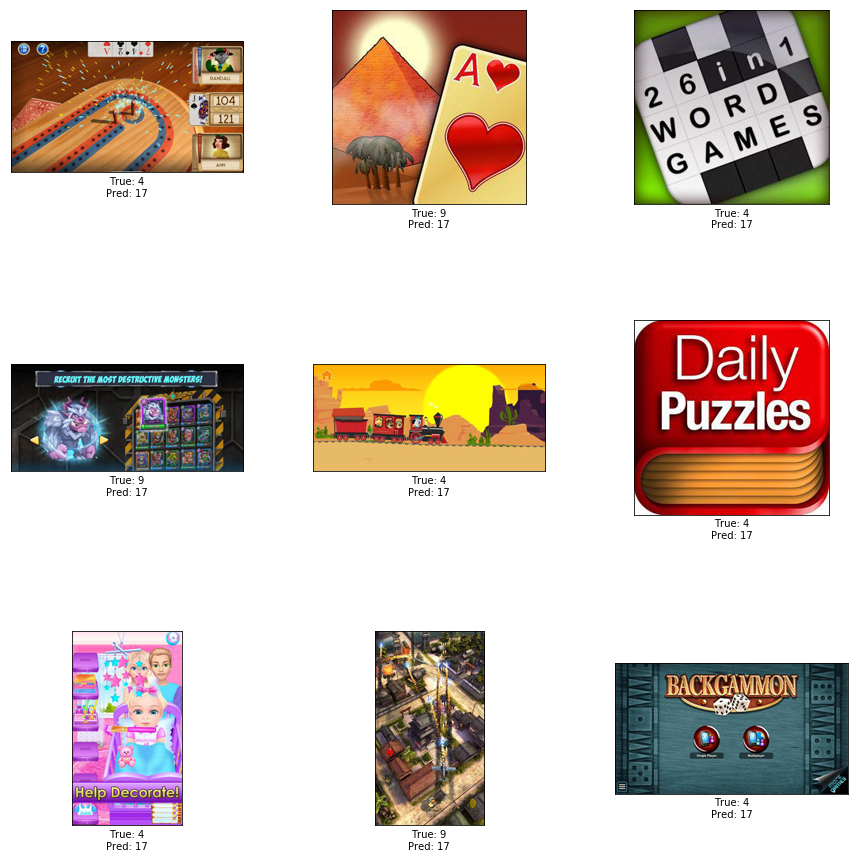

Confusion Matrix:
[0 0 0 0 0] (0) 4
[2675    0    0    0    0] (1) 9
[545   0   0   0   0] (2) 12
[854   0   0   0   0] (3) 17
 (0) (1) (2) (3)


In [162]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [190]:
df.columns

Index(['picname', 'label', 'pic', 'Description', 'Rate', 'Ratecount',
       'Version', 'Author', 'new_version', 'new_version2', 'new_version3',
       'weighted', 'AppName', 'DescriptionSolved', 'picpath', 'appname',
       'RateClass', 'Reason', 'label_y'],
      dtype='object')

In [193]:
cc = ['picname', 'label', 'Description', 'Rate', 'Ratecount',
       'Version', 'Author', 'new_version', 'new_version2', 'new_version3',
       'weighted',  'DescriptionSolved', 'picpath', 'appname',
       'RateClass', 'Reason', 'label_y']
df2 = pd.DataFrame(df, columns=cc)

In [218]:
df = df.drop_duplicates(['picname'])

In [217]:
df2 = df2.drop_duplicates(['picname'])

In [213]:
df3 = df2[df2['appname']=='Vainglory']

In [230]:
app = []
for i in df['appname'].value_counts().index.tolist():
    app.append(i)

In [231]:
df4 = pd.DataFrame(app, columns = ['appname'])
df4['picno'] = NO

In [235]:
df4 = df4.merge(df2, left_on='appname', right_on='appname',how = 'inner')

In [238]:
df4 = df4.drop_duplicates(['appname'])

In [247]:
df4 = df4.reset_index(drop = True)

In [248]:
l5 = []
l4 = []
l3 = []
l2 = []
l1 = []
for j in range(df4.shape[0]):
    if df4['picno'][j] == 5:
        l5.append(df4['label_x'][j])
    if df4['picno'][j] == 4:
        l4.append(df4['label_x'][j])  
    if df4['picno'][j] == 3:
        l3.append(df4['label_x'][j])        
    if df4['picno'][j] == 2:
        l2.append(df4['label_x'][j])
    if df4['picno'][j] == 1:
        l1.append(df4['label_x'][j])        

In [249]:
pd.Series(l5).value_counts()

4     1973
12     587
9      422
17     152
dtype: int64

In [250]:
pd.Series(l4).value_counts()

4     413
12    134
9      88
17     25
dtype: int64

In [251]:
pd.Series(l3).value_counts()

4     341
12    104
9      60
17     21
dtype: int64

In [252]:
pd.Series(l2).value_counts()

4     340
12    123
9      65
17     20
dtype: int64

In [253]:
pd.Series(l1).value_counts()

4     267
12     77
9      62
17     27
dtype: int64

In [225]:
df['appname'].value_counts()

ABC Games for Kids-EduKittyABC                                                    5
Best Brokers Stock Market Game                                                    5
TankTigersES                                                                      5
Mad Dex                                                                           5
Infinite Block Puzzle                                                             5
Skin Creator 3D for Minecraft                                                     5
Klondike Solitaire Card Games                                                     5
Raining Balloons                                                                  5
Beach Buggy Blitz                                                                 5
Ice Princess Sweet Sixteen                                                        5
Rail Maze Pro HD                                                                  5
Dead Tide                                                                   

In [219]:
NO = df2.groupby('appname').appname.count().to_list()

In [220]:
from collections import Counter
Counter(NO)

Counter({5: 3134, 4: 660, 2: 548, 3: 526, 1: 433})

In [223]:
pd.Series(NO).value_counts()

5    3134
4     660
2     548
3     526
1     433
dtype: int64